# Simulacion en python

Cola tipo M/M/1

In [2]:
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scipy

     ---------------------------------------- 0.0/61.2 kB ? eta -:--:--
     ------ --------------------------------- 10.2/61.2 kB ? eta -:--:--
     ------------------- ------------------ 30.7/61.2 kB 330.3 kB/s eta 0:00:01
     -------------------------------------- 61.2/61.2 kB 467.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.8 MB 4.3 MB/s eta 0:00:04
   - -------------------------------------- 0.6/15.8 MB 8.8 MB/s eta 0:00:02
   --- ------------------------------------ 1.2/15.8 MB 9.5 MB/s eta 0:00:02
   ---- ----------------------------------- 1.6/15.8 MB 9.3 MB/s eta 0:00:02
   ----- ---------------------------------- 2.3/15.8 MB 10.2 MB/s eta 0:00:02
   ------- -------------------------------- 2.8/15.8 MB 10.5 MB/s eta 0:00:02
   -------- ------------------------------- 3.3/15.8 MB 10.7 MB/s eta 0:00:02
   --------- ------------------------------ 3.9/15.8 MB 11.2 MB/s eta 0:00:02
   --

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Ejemplo

El reconocido Internista, Dr. Casas quiere colocar una consulta médica para poder atender directamente a sus pacientes.

En promedio, sus colegas le dicen que a sus consultas llega un paciente cada 10 minutos.
Esto le preocupa porque le gusta tomar su tiempo y espera atender un paciente cada 25 minutos.
Por lo que debe estimar el tamaño de su sala de espera.

El edificio permite entrada desde las 9:00 hasta 19:00. 

Inicialmente, vamos a crear un objeto que contendra los parametros de nuestro sistema

In [4]:
# Definicion de parametros
# Utilizando un diccionario, vamos a definir los parametros de la simulacion

def construir_params(n, tasa_llegada, tasa_servicio, t_max):
    return {
        'n': n, # Numero de observaciones
        'tasa_llegada_media': tasa_llegada, # Tasa de llegada media
        'tasa_servicio_media': tasa_servicio, # Tasa de servicio media
        'tiempo_entre_llegadas': 1 / tasa_llegada, # Tiempo entre llegadas
        'tiempo_servicio': 1 / tasa_servicio, # Tiempo de servicio
        'bins': int(n / tasa_llegada), # Numero de bins para el histograma
        't_max': t_max, # Tiempo maximo de simulacion
    }

params = construir_params(10000, 10, 15, 600)
print(params)

{'n': 10000, 'tasa_llegada_media': 10, 'tasa_servicio_media': 15, 'tiempo_entre_llegadas': 0.1, 'tiempo_servicio': 0.06666666666666667, 'bins': 1000, 't_max': 600}


In [3]:
# La simulacion en si
dist_llegada = stats.expon(scale=params['tasa_llegada_media'])
dist_servicio = stats.expon(scale=params['tasa_servicio_media'])

# Lo primero es identificar los momentos de llegada de los pacientes
t_entrellegada = dist_llegada.rvs(size=params['n'])
t_llegada = np.cumsum(t_entrellegada) # Tiempo de llegada de cada paciente

# limitaremos al tiempo de simulacion
if t_llegada[-1] > params['t_max']:
    print('Existen mas eventos que el tiempo maximo de simulacion')
    eventos_validos = t_llegada <= params['t_max'] # Eventos validos
    t_llegada = t_llegada[eventos_validos] # Tiempo de llegada de cada paciente
    t_entrellegada = t_entrellegada[eventos_validos] # Tiempo entre llegada de cada paciente
    print(f'Existen {len(t_llegada)} eventos validos. N actualizado')
    params['n'] = len(t_llegada)
else:
    print('No se alcanzo el tiempo maximo de simulacion')

t_servicio = dist_servicio.rvs(size=params['n']) # Tiempo de servicio de cada paciente
n_nuevo = len(t_llegada) # Numero de pacientes que llegaron
params = construir_params(n_nuevo, 10, 25, 600) # Actualizamos el numero de pacientes

print(params)


Existen mas eventos que el tiempo maximo de simulacion
Existen 54 eventos validos. N actualizado
{'n': 54, 'tasa_llegada_media': 10, 'tasa_servicio_media': 25, 'tiempo_entre_llegadas': 0.1, 'tiempo_servicio': 0.04, 'bins': 5, 't_max': 600}


In [4]:
# Calculamos el tiempo de atencion de cada paciente
jobs_df = pd.DataFrame({
    't_entrellegada': t_entrellegada,
    't_llegada': t_llegada,
    't_servicio': t_servicio,
    't_inicio': np.zeros(params['n']),
    't_fin': np.zeros(params['n']),
})

jobs_df.head()

,t_entrellegada,t_llegada,t_servicio,t_inicio,t_fin
0,8.315524,8.315524,12.140505,0.0,0.0
1,17.121554,25.437078,19.863673,0.0,0.0
2,15.053740,40.490818,13.494361,0.0,0.0
3,15.014830,55.505648,13.452067,0.0,0.0
4,2.491582,57.997231,0.531475,0.0,0.0


In [5]:
#El primer paciente inicia al llegar al consultorio
jobs_df.loc[0, 't_inicio'] = jobs_df.loc[0,'t_llegada'] #Paciente inicia al llegar al consultorio
jobs_df.loc[0, 't_fin'] = jobs_df.loc[0,'t_inicio'] + jobs_df.loc[0, 't_servicio'] #Sale t_servicio despues.

# El resto de los pacientes inician cuando termina el anterior
# Este se itera sobre el dataframe
for i in range(1, params['n']):
    jobs_df.loc[i, 't_inicio'] = max(jobs_df.loc[i, 't_llegada'], jobs_df.loc[i-1, 't_fin']) #
    jobs_df.loc[i, 't_fin'] = jobs_df.loc[i, 't_inicio'] + jobs_df.loc[i, 't_servicio']

jobs_df.head()

,t_entrellegada,t_llegada,t_servicio,t_inicio,t_fin
0,8.315524,8.315524,12.140505,8.315524,20.456028
1,17.121554,25.437078,19.863673,25.437078,45.300752
2,15.053740,40.490818,13.494361,45.300752,58.795112
3,15.014830,55.505648,13.452067,58.795112,72.247179
4,2.491582,57.997231,0.531475,72.247179,72.778654


In [6]:
# Teniendo esto, podemos determinar el tiempo de respuesta y el tiempo de espera
jobs_df['t_respuesta'] = jobs_df['t_fin'] - jobs_df['t_llegada']
jobs_df['t_espera'] = jobs_df['t_inicio'] - jobs_df['t_llegada']

jobs_df.head()

,t_entrellegada,t_llegada,t_servicio,t_inicio,t_fin,t_respuesta,t_espera
0,8.315524,8.315524,12.140505,8.315524,20.456028,12.140505,0.000000
1,17.121554,25.437078,19.863673,25.437078,45.300752,19.863673,0.000000
2,15.053740,40.490818,13.494361,45.300752,58.795112,18.304294,4.809933
3,15.014830,55.505648,13.452067,58.795112,72.247179,16.741531,3.289464
4,2.491582,57.997231,0.531475,72.247179,72.778654,14.781423,14.249948


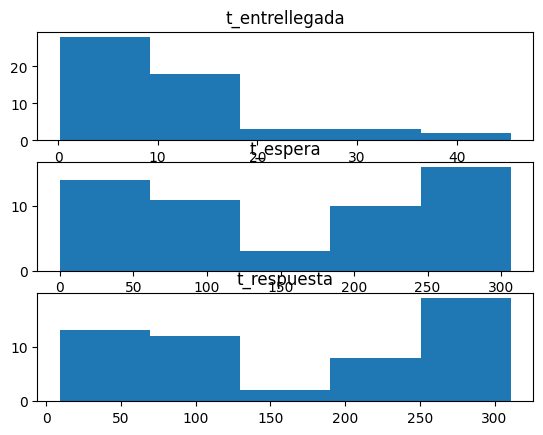

In [7]:
plot_struct = [['t_entrellegada'],['t_espera'],['t_respuesta']]

fig, ax = plt.subplot_mosaic(plot_struct)
for kind in ['t_entrellegada', 't_espera', 't_respuesta']:
    ax[kind].hist(jobs_df[kind], bins=params['bins'])
    ax[kind].set_title(kind)

In [8]:
# Calcular respecto a los eventos, de modo de que podamos estimar la cantidad de personas en la cola
events_df = pd.DataFrame(columns=['lim_inf', 'lim_sup', 'ancho', 'n_en_espera', 'n_en_sistema'])

lim_inf = 0.
idx_llegada, idx_inicio, idx_fin =0, 0, 0
n_en_espera = 0
n_en_sistema = 0
#vamos a revisar por id de paciente...
while idx_fin < params['n']:
    llegada = jobs_df.loc[idx_llegada, 't_llegada'] if idx_llegada < params['n'] else np.inf
    inicio = jobs_df.loc[idx_inicio, 't_inicio'] if idx_inicio < params['n'] else np.inf
    salida = jobs_df.loc[idx_fin, 't_fin']

    # Casos posibles
    # Llegada es menor que inicio y salida: en espera
    if np.all([llegada <= inicio, llegada <= salida]):
        lim_sup = llegada
        n_cambio, nq_cambio =1, 1 # Cambio en el numero de personas en el sistema y en la cola
        idx_llegada += 1
    # Inicio es menor que llegada y salida: en servicio
    elif np.all([inicio <= llegada, inicio <= salida]):
        lim_sup = inicio
        n_cambio, nq_cambio = 0, -1 # Cambio en el numero de personas en el sistema y en la cola
        idx_inicio += 1
    # Salida es menor que llegada y inicio: en salida
    else:
        lim_sup = salida
        n_cambio, nq_cambio = -1, 0
        idx_fin += 1
    
    ancho = lim_sup - lim_inf

    # Registramos el evento
    new_event = pd.DataFrame({
        'lim_inf': lim_inf,
        'lim_sup': lim_sup,
        'ancho': ancho,
        'n_en_espera': n_en_espera,
        'n_en_sistema': n_en_sistema,
        'diff_n_en_sistema': n_cambio,
        'diff_n_en_espera': nq_cambio,
    }, index=[0])

    #y lo concatenamos
    events_df = pd.concat([events_df, new_event], ignore_index=True)

    # Actualizamos los valores de los contadores de en sistema y en espera
    n_en_sistema += n_cambio
    n_en_espera += nq_cambio
    lim_inf = lim_sup

events_df.head()

/tmp/ipykernel_3874/1609506366.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events_df = pd.concat([events_df, new_event], ignore_index=True)


,lim_inf,lim_sup,ancho,n_en_espera,n_en_sistema,diff_n_en_sistema,diff_n_en_espera
0,0.000000,8.315524,8.315524,0,0,1.0,1.0
1,8.315524,8.315524,0.000000,1,1,0.0,-1.0
2,8.315524,20.456028,12.140505,0,1,-1.0,0.0
3,20.456028,25.437078,4.981050,0,0,1.0,1.0
4,25.437078,25.437078,0.000000,1,1,0.0,-1.0


In [9]:
# Estimamos el tiempo total que tomaria atender a todos los pacientes que llegaron en el tiempo de simulacion
ancho_total = jobs_df.iloc[-1]['t_fin'] - jobs_df.iloc[0]['t_llegada']
print(f'Ancho total: {ancho_total:.2f} minutos -> {ancho_total / 60:.2f} horas')

Ancho total: 899.04 minutos -> 14.98 horas


In [10]:

# Estimaremos algunas metricas 
def obtener_metricas(params, jobs_df, events_df):
    #metricas del sistema
    sim_interllegada_media = jobs_df['t_entrellegada'].mean()
    sim_tasa_llegada_media = 1 / sim_interllegada_media
    sim_t_servicio_media = jobs_df['t_servicio'].mean()
    sim_tasa_servicio_media = 1 / sim_t_servicio_media
    sim_t_espera_media = jobs_df['t_espera'].mean()
    sim_t_respuesta_media = jobs_df['t_respuesta'].mean()
    sim_t_respuesta_std = jobs_df['t_respuesta'].std()

    #metricas de eventos
    ancho = events_df['ancho']
    n_en_sistema_ponderado = (events_df['n_en_sistema'] * ancho).sum()
    n_en_espera_ponderado = (events_df['n_en_espera'] * ancho).sum()
    sim_n_en_sistema_media = n_en_sistema_ponderado / ancho_total
    sim_n_en_espera_media = n_en_espera_ponderado / ancho_total

    #throughput
    eventos_salidas = events_df['diff_n_en_sistema'] == -1
    salidas = events_df.loc[eventos_salidas, 'lim_inf']
    hist, _ = np.histogram(salidas, bins=int(ancho_total)+1)
    sim_throughput = hist.mean()

    #utilizacion
    ocupado = (jobs_df['t_fin'] - jobs_df['t_inicio']).sum()
    sim_utilizacion = ocupado / ancho_total

    return {
        'duracion_total': ancho_total,
        'tasa_llegada_media': sim_tasa_llegada_media,
        't_entrellegada_media': sim_interllegada_media,
        'tasa_servicio_media': sim_tasa_servicio_media,
        't_servicio_media': sim_t_servicio_media,
        't_espera_media': sim_t_espera_media,
        't_respuesta_media': sim_t_respuesta_media,
        't_respuesta_std': sim_t_respuesta_std,
        'n_en_sistema_media': sim_n_en_sistema_media,
        'n_en_espera_media': sim_n_en_espera_media,
        'throughput': sim_throughput,
        'utilizacion': sim_utilizacion,
    }

In [11]:
metricas = obtener_metricas(params, jobs_df, events_df)

for k, v in metricas.items():
    print(f'{k}: {v:.2f}')

duracion_total: 899.04
tasa_llegada_media: 0.09
t_entrellegada_media: 11.08
tasa_servicio_media: 0.06
t_servicio_media: 16.15
t_espera_media: 150.33
t_respuesta_media: 166.48
t_respuesta_std: 109.67
n_en_sistema_media: 10.00
n_en_espera_media: 9.03
throughput: 0.06
utilizacion: 0.97


Text(0.5, 1.0, 'Tiempo de respuesta')

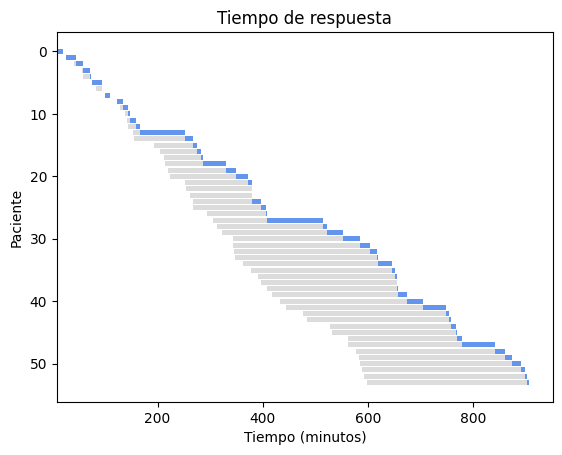

In [12]:
# Graficamos el tiempo de respuesta

fig, ax = plt.subplots()
ax.barh(
    y=jobs_df.index,
    left=jobs_df['t_llegada'],
    width=jobs_df['t_espera'],
    color='gainsboro',
)
ax.barh(
    y=jobs_df.index,
    left=jobs_df['t_inicio'],
    width=jobs_df['t_servicio'],
    color='cornflowerblue',
)
ax.invert_yaxis()
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Paciente')
ax.set_title('Tiempo de respuesta')

(0.0, 10.0)

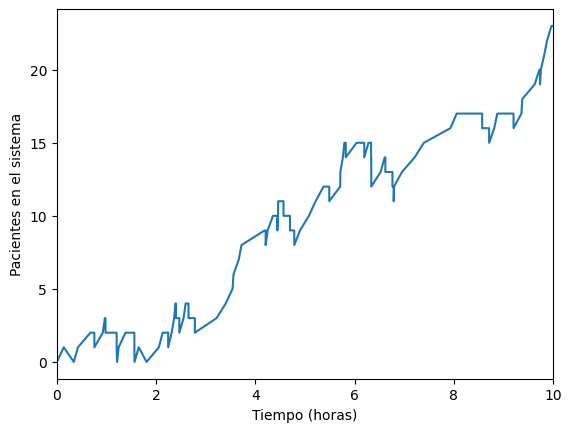

In [13]:
#Pacientes en el sistema
fig, ax = plt.subplots()
ax.plot(events_df['lim_inf']/60, events_df['n_en_sistema'])
ax.set_xlabel('Tiempo (horas)')
ax.set_ylabel('Pacientes en el sistema')
ax.set_xlim(0, params['t_max']/60)

## Perfect!
Podemos averiguar cuantos pacientes puede atender, cuanto demorara en atender si llegan a cierta velocidad, etc...


# Caso 2

Esta vez queremos ver si la lista de espera aumenta segun los doctores disponibles

In [14]:
# Nuestros nuevos parametros
tasa_llegada = 20 # 1 cada 15 minutos
tasa_servicio = [15, 20, 23, 25] # Lista con la atencion media de cada medico
n = 1000
params = {
    'tasa_llegada_media': tasa_llegada,
    'tasa_servicio_media': tasa_servicio,
    't_max': 600, # 10 horas
    'n_medicos': len(tasa_servicio), # 2 medicos
    't_entrellegada': 1/15, # 1 cada 15 minutos
    't_servicio': [1/v for v in tasa_servicio],
    'n': n,
}


In [15]:
# Simulacion

# Definimos las distribuciones
dist_llegada = stats.expon(scale=params['tasa_llegada_media'])
# Para cada medico, definimos una distribucion de servicio
dist_medicos = {i: stats.expon(scale=params['tasa_servicio_media'][i]) for i in range(params['n_medicos'])}

# Lo primero es identificar los momentos de llegada de los pacientes
t_entrellegada = dist_llegada.rvs(size=params['n'])
t_llegada = np.cumsum(t_entrellegada) # Tiempo de llegada de cada paciente  

# limitaremos al tiempo de simulacion
eventos_validos = t_llegada <= params['t_max'] # Eventos validos
t_entrellegada = t_entrellegada[eventos_validos] # Tiempo entre llegada de cada paciente
t_llegada = t_llegada[eventos_validos] # Tiempo de llegada de cada paciente
params['n'] = len(t_llegada) # Numero de pacientes que llegaron

print(params)

{'tasa_llegada_media': 20, 'tasa_servicio_media': [15, 20, 23, 25], 't_max': 600, 'n_medicos': 4, 't_entrellegada': 0.06666666666666667, 't_servicio': [0.06666666666666667, 0.05, 0.043478260869565216, 0.04], 'n': 31}


In [16]:
# Simularemos el primer paciente
jobs_df = pd.DataFrame({
    't_entrellegada': t_entrellegada,
    't_llegada': t_llegada,
    't_servicio': np.zeros(params['n']),
    't_inicio': np.zeros(params['n']),
    't_fin': np.zeros(params['n']),
})
jobs_df['medico'] = pd.Categorical(np.zeros(params['n']), categories=range(params['n_medicos']))

medicos_ocupados = [False]*int(params['n_medicos']) # Lista de medicos ocupados
# El primer paciente inicia al llegar al consultorio

jobs_df.loc[0, 't_inicio'] = jobs_df.loc[0,'t_llegada'] #Paciente inicia al llegar al consultorio
idx_medico = medicos_ocupados.index(False) # Buscamos el primer medico disponible
jobs_df.loc[0, 'medico'] = idx_medico # Lo asignamos
jobs_df.loc[0, 't_servicio'] = dist_medicos[idx_medico].rvs() # Tiempo de servicio del medico
jobs_df.loc[0, 't_fin'] = jobs_df.loc[0,'t_inicio'] + jobs_df.loc[0, 't_servicio'] #tiempo de salida
medicos_ocupados[idx_medico] = True # El medico esta ocupado

# El resto de los pacientes inician cuando termina el anterior
# Este se itera sobre el dataframe
for i in range(1, params['n']):
    jobs_df.loc[i, 't_inicio'] = max(jobs_df.loc[i, 't_llegada'], jobs_df.loc[i-1, 't_fin']) #
    #Si hay medicos disponibles, se asigna el primero disponible
    if sum(medicos_ocupados) < params['n_medicos']:
        idx_medico = medicos_ocupados.index(False)
        jobs_df.loc[i, 'medico'] = idx_medico # Lo asignamos
        jobs_df.loc[i, 't_servicio'] = dist_medicos[idx_medico].rvs()
        jobs_df.loc[i, 't_fin'] = jobs_df.loc[i, 't_inicio'] + jobs_df.loc[i, 't_servicio']
        medicos_ocupados[idx_medico] = True # El medico esta ocupado
    else:
        # Si no hay medicos disponibles, se asigna al que termine primero
        idx_medico = jobs_df.groupby('medico').max()['t_fin'].idxmin()
        medicos_ocupados[idx_medico] = False
        jobs_df.loc[i, 'medico'] = idx_medico
        jobs_df.loc[i, 't_servicio'] = dist_medicos[idx_medico].rvs()
        jobs_df.loc[i, 't_fin'] = jobs_df.loc[i, 't_inicio'] + jobs_df.loc[i, 't_servicio']
        medicos_ocupados[idx_medico] = True
    
    # Revisamos si el los medicos que estan ocupados termina antes que t_inicio
    t_fin_medicos = jobs_df.groupby('medico', observed=False).max()['t_fin']
    ya_desocupados = (t_fin_medicos < jobs_df.loc[i, 't_inicio']).to_list()
    #corregimos los medicos que ya estan desocupados
    medicos_ocupados = [False if ya_desocupados[i] else medicos_ocupados[i] for i in range(params['n_medicos'])] #Si ya termino, se desocupa. Si no, se mantiene



In [17]:
jobs_df['t_respuesta'] = jobs_df['t_fin'] - jobs_df['t_llegada']
jobs_df['t_espera'] = jobs_df['t_inicio'] - jobs_df['t_llegada']

jobs_df.head()

,t_entrellegada,t_llegada,t_servicio,t_inicio,t_fin,medico,t_respuesta,t_espera
0,11.307964,11.307964,8.837178,11.307964,20.145141,0,8.837178,0.000000
1,58.708502,70.016466,11.600217,70.016466,81.616683,1,11.600217,0.000000
2,0.732184,70.748649,11.256159,81.616683,92.872842,0,22.124193,10.868034
3,3.120610,73.869259,12.318990,92.872842,105.191832,2,31.322573,19.003583
4,6.735859,80.605118,0.407266,105.191832,105.599098,1,24.993980,24.586714


In [18]:
# Tabla de eventos
events_df = pd.DataFrame(columns=['lim_inf', 'lim_sup', 'ancho', 'n_en_espera', 'n_en_sistema'])

lim_inf = 0.
idx_llegada, idx_inicio, idx_fin =0, 0, 0
n_por_medico = [0]*params['n_medicos']
n_en_espera = 0
n_en_sistema = 0

while idx_fin < params['n']:
    llegada = jobs_df.loc[idx_llegada, 't_llegada'] if idx_llegada < params['n'] else np.inf
    inicio = jobs_df.loc[idx_inicio, 't_inicio'] if idx_inicio < params['n'] else np.inf
    salida = jobs_df.loc[idx_fin, 't_fin']

    # Casos posibles
    # Llegada es menor que inicio y salida: en espera
    if np.all([llegada <= inicio, llegada <= salida]):
        lim_sup = llegada
        n_cambio, nq_cambio =1, 1 # Cambio en el numero de personas en el sistema y en la cola
        idx_llegada += 1
    # Inicio es menor que llegada y salida: en servicio
    elif np.all([inicio <= llegada, inicio <= salida]):
        lim_sup = inicio
        n_cambio, nq_cambio = 0, -1 # Cambio en el numero de personas en el sistema y en la cola
        idx_inicio += 1
    # Salida es menor que llegada y inicio: en salida
    else:
        lim_sup = salida
        n_cambio, nq_cambio = -1, 0
        idx_fin += 1
    
    ancho = lim_sup - lim_inf
    events_df = pd.concat([events_df, pd.DataFrame({
        'lim_inf': lim_inf,
        'lim_sup': lim_sup,
        'ancho': ancho,
        'n_en_espera': n_en_espera,
        'n_en_sistema': n_en_sistema,
        'diff_n_en_sistema': n_cambio,
        'diff_n_en_espera': nq_cambio,
    }, index=[0])], ignore_index=True)

    # Actualizamos los valores de los contadores de en sistema y en espera
    n_en_sistema += n_cambio
    n_en_espera += nq_cambio
    lim_inf = lim_sup

events_df.tail()

/tmp/ipykernel_3874/2108711437.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  events_df = pd.concat([events_df, pd.DataFrame({


,lim_inf,lim_sup,ancho,n_en_espera,n_en_sistema,diff_n_en_sistema,diff_n_en_espera
88,691.314009,701.503720,10.189711,2,3,0.0,-1.0
89,701.503720,701.503720,0.000000,1,3,-1.0,0.0
90,701.503720,705.674115,4.170395,1,2,0.0,-1.0
91,705.674115,705.674115,0.000000,0,2,-1.0,0.0
92,705.674115,729.855936,24.181822,0,1,-1.0,0.0


Y finalmente ploteamos

Text(0.5, 1.0, 'Tiempo de respuesta')

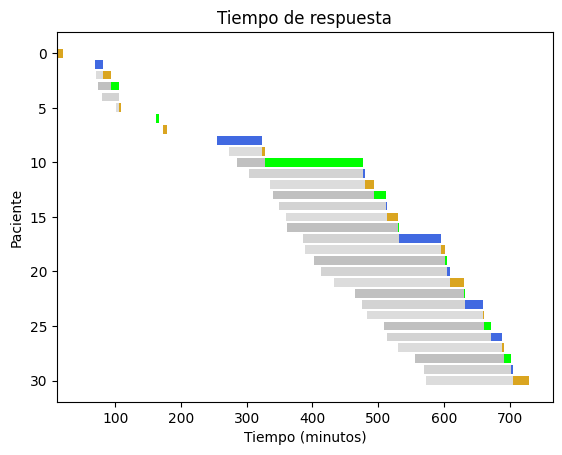

In [19]:
fig, ax = plt.subplots()
grises = ['gainsboro', 'lightgray', 'silver', 'darkgray']
colores = ['goldenrod', 'royalblue', 'lime', 'crimson']

for medico in range(params['n_medicos']):
    b_espera = ax.barh(
        y=jobs_df[jobs_df['medico'] == medico].index,
        left=jobs_df[jobs_df['medico'] == medico]['t_llegada'],
        width=jobs_df[jobs_df['medico'] == medico]['t_espera'],
        color=grises[medico],
    )
    b_uso = ax.barh(
        y=jobs_df[jobs_df['medico'] == medico].index,
        left=jobs_df[jobs_df['medico'] == medico]['t_inicio'],
        width=jobs_df[jobs_df['medico'] == medico]['t_servicio'],
        color=colores[medico],
    )
    ax.set_label(f'Medico {medico}')

ax.invert_yaxis()
ax.set_xlabel('Tiempo (minutos)')
ax.set_ylabel('Paciente')
ax.set_title('Tiempo de respuesta')

(0.0, 10.0)

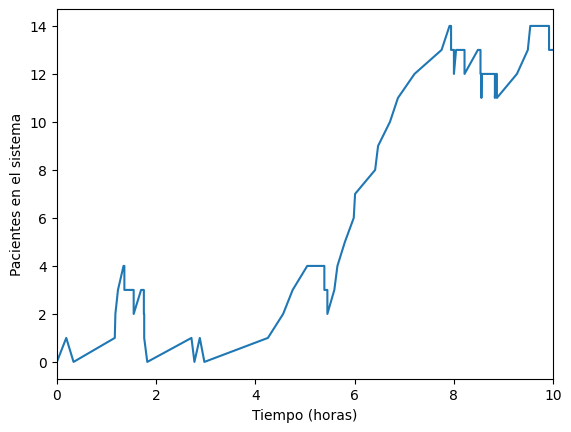

In [20]:
#Pacientes en el sistema
fig, ax = plt.subplots()
ax.plot(events_df['lim_inf']/60, events_df['n_en_sistema'])
ax.set_xlabel('Tiempo (horas)')
ax.set_ylabel('Pacientes en el sistema')
ax.set_xlim(0, params['t_max']/60)